<a href="https://colab.research.google.com/github/usshaa/SMBDA/blob/main/C-5.14%3A%20Realtime_Data_Streaming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Setting up Spark Session and Imports

- This sets up a Spark session named "WeatherStream" which allows us to work with Spark DataFrames.
- Various necessary imports are included (`pyspark`, `SparkSession`, `functions`, `types`, `time`).

In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import time

In [ ]:
# Create a SparkSession
spark = SparkSession.builder.appName("WeatherStream").getOrCreate()

### 2. Define API Endpoint and Function to Retrieve Weather Data

In [ ]:
# Define the API endpoint and parameters
url = "https://api.openweathermap.org/data/2.5/weather"
params = {"appid": "5898bcd49cdacd900ef3d429693c887a"}  # Replace with your API key

- `get_weather(city)`: A function to call the OpenWeatherMap API and retrieve weather data for a given city.
- The function returns a dictionary with timestamp, city name, temperature (`temp` in Kelvin), and wind speed (`wind_speed`).

In [ ]:
def get_weather(city):
    import requests
    response = requests.get(url, params={"q": city, "appid": params["appid"]})
    if response.status_code == 200:
        weather_data = response.json()
        return {
            "timestamp": int(time.time()),  # Current timestamp when data was retrieved
            "city": city,
            "temp": weather_data["main"]["temp"],
            "wind_speed": weather_data["wind"]["speed"]
        }
    else:
        return None

### 3. Define Schema for Weather Data

- Defines the schema for the weather data which includes timestamp, city, temperature in Celsius (`temp`), and wind speed.

In [ ]:
schema = StructType([
    StructField("timestamp", LongType()),
    StructField("city", StringType()),
    StructField("temp", DoubleType()),
    StructField("wind_speed", DoubleType())
])

### 4. Define User Defined Function (UDF) to Call API Function

- `weather_udf(city)`: A UDF that uses `get_weather` function to fetch weather data and returns it according to the defined schema.

In [ ]:
@udf(schema)
def weather_udf(city):
    return get_weather(city)

### 5. Create Streaming DataFrame (for demonstration)

- Creates a streaming DataFrame (`df`) for demonstration using a rate source, producing 1 row per second.

In [ ]:
df = spark.readStream.format("rate").option("rowsPerSecond", 1).load()

### 6. Apply UDF to Streaming DataFrame to Fetch Weather Data

- Applies the `weather_udf` UDF to fetch weather data for a specified city ("London" in this case).

In [ ]:
df = df.withColumn("weather_data", weather_udf(lit("India")))

### 7. Extract Relevant Fields from JSON Response

- Extracts timestamp, city, temperature, and wind speed from the nested JSON response obtained from the API call.

In [ ]:
df = df.withColumn("timestamp", col("weather_data.timestamp")) \
       .withColumn("city", col("weather_data.city")) \
       .withColumn("temp", col("weather_data.temp")) \
       .withColumn("wind_speed", col("weather_data.wind_speed")) \
       .select("timestamp", "city", "temp", "wind_speed")

### 8. Start Streaming Query to Write to Parquet Files

- Starts the streaming query to write the streaming DataFrame (`df`) to Parquet files.
- `awaitTermination(timeout=10)` waits for the streaming query to run for 10 seconds.

In [ ]:
query = df.writeStream \
   .outputMode("append") \
   .format("parquet") \
   .option("path", "/FileStore/table/myfile")\
   .option("checkpointLocation", "/FileStore/table/path_to_checkpoint_location")\
   .start()
query.awaitTermination(timeout=1000)

In [ ]:
query.awaitTermination(timeout=100)

Out[13]: True

In [ ]:
query.stop()

### Step 1. Load Saved Parquet Data After Streaming Completes

- Loads the saved Parquet data from the directory where it was written during streaming.

In [ ]:
data = spark.read.parquet("/FileStore/table/myfile")
data.show()

+----------+------+------+----------+
| timestamp|  city|  temp|wind_speed|
+----------+------+------+----------+
|1732763280|London|275.11|      2.06|
|1732763280|London|275.11|      2.06|
|1732763280|London|275.11|      2.06|
|1732763280|London|275.11|      2.06|
|1732763280|London|275.11|      2.06|
|1732763280|London|275.11|      2.06|
|1732763282|London|275.11|      2.06|
|1732763282|London|275.11|      2.06|
|1732763282|London|275.11|      2.06|
|1732763282|London|275.11|      2.06|
|1732763282|London|275.11|      2.06|
|1732763283|London|275.11|      2.06|
|1732763285|London|275.11|      2.06|
|1732763285|London|275.11|      2.06|
|1732763286|London|275.11|      2.06|
|1732763287|London|275.11|      2.06|
|1732763288|London|275.11|      2.06|
|1732763289|London|275.11|      2.06|
|1732763291|London|275.11|      2.06|
|1732763291|London|275.11|      2.06|
+----------+------+------+----------+
only showing top 20 rows



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import from_unixtime, hour

In [ ]:
# Drop rows with missing values
data_cleaned = data.dropna()

In [ ]:
# Convert timestamp to hour of day
data_cleaned = data_cleaned.withColumn("hour_of_day", hour(from_unixtime(data_cleaned["timestamp"])))

In [ ]:
# Drop unnecessary columns
data_cleaned = data_cleaned.drop("timestamp")

In [ ]:
# Assemble features into a single vector
assembler = VectorAssembler(inputCols=["temp", "wind_speed", "hour_of_day"], outputCol="features")
data_assembled = assembler.transform(data_cleaned)

In [ ]:
# Train a K-means model
kmeans = KMeans().setK(3).setSeed(42)
model = kmeans.fit(data_assembled)

In [ ]:
# Make predictions
predictions = model.transform(data_assembled)

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
predictions_pd = predictions.select("temp", "wind_speed", "hour_of_day", "prediction").toPandas()
predictions_pd

,temp,wind_speed,hour_of_day,prediction
0,275.11,2.06,3,0
1,275.11,2.06,3,0
2,275.11,2.06,3,0
3,275.11,2.06,3,0
4,275.11,2.06,3,0
...,...,...,...,...
256,275.11,2.06,3,0
257,275.11,2.06,3,0
258,275.11,2.06,3,0
259,275.11,2.06,3,0


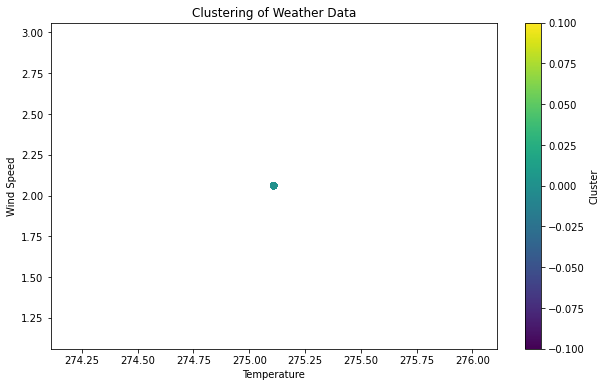

In [ ]:
# Scatter plot of features colored by predicted cluster
# Sample a subset of data for visualization
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd["temp"], predictions_pd["wind_speed"], c=predictions_pd["prediction"], cmap='viridis')
plt.xlabel('Temperature')
plt.ylabel('Wind Speed')
plt.title('Clustering of Weather Data')
plt.colorbar(label='Cluster')
plt.xlim(predictions_pd["temp"].min() - 1, predictions_pd["temp"].max() + 1)
plt.ylim(predictions_pd["wind_speed"].min() - 1, predictions_pd["wind_speed"].max() + 1)
plt.show()

#### Make Predictions:
Use the trained model to make predictions on your data.

In [ ]:
predictions = model.transform(data_assembled)

#### Extract Predicted Cluster Labels:
Extract the predicted cluster labels from the predictions DataFrame.

In [ ]:
predicted_labels = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

#### Compute Silhouette Score:
Calculate the silhouette score using the silhouette_score function from sklearn.metrics.

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [ ]:
# Convert predictions DataFrame to Pandas DataFrame for silhouette score calculation
predictions_pd = predictions.select("temp", "wind_speed", "hour_of_day", "prediction").toPandas()
predictions_pd

,temp,wind_speed,hour_of_day,prediction
0,275.11,2.06,3,0
1,275.11,2.06,3,0
2,275.11,2.06,3,0
3,275.11,2.06,3,0
4,275.11,2.06,3,0
...,...,...,...,...
256,275.11,2.06,3,0
257,275.11,2.06,3,0
258,275.11,2.06,3,0
259,275.11,2.06,3,0


In [ ]:
# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(predictions_pd[["temp", "wind_speed", "hour_of_day"]])

In [ ]:
# Compute silhouette score
silhouette_avg = silhouette_score(scaled_features, predicted_labels)
print(f"Silhouette Score: {silhouette_avg}")

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-1926133685684794>:2
      1 # Compute silhouette score
----> 2 silhouette_avg = silhouette_score(scaled_features, predicted_labels)
      3 print(f"Silhouette Score: {silhouette_avg}")

File /databricks/python/lib/python3.9/site-packages/sklearn/metrics/cluster/_unsupervised.py:117, in silhouette_score(X, labels, metric, sample_size, random_state, **kwds)
    115     else:
    116         X, labels = X[indices], labels[indices]
--> 117 return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))

File /databricks/python/lib/python3.9/site-packages/sklearn/metrics/cluster/_unsupervised.py:227, in silhouette_samples(X, labels, metric, **kwds)
    225 n_samples = len(labels)
    226 label_freqs = np.bincount(labels)
--> 227 check_number_of_labels(len(le.classes_), n_samples)
    229 kwds["metric"] = metric
    230 red

### Steps to Determine Cluster for a New Sample

1. **Prepare the New Sample**:
Prepare your new sample data in a format consistent with your model's training data. This typically involves assembling the features into a vector using `VectorAssembler`.

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
# Example new sample data (replace with your actual data)
new_sample = [(286.13, 3, 2)]  # (temp, wind_speed, hour_of_day)

In [ ]:
# Convert to Spark DataFrame
new_sample_df = spark.createDataFrame(new_sample, ["temp", "wind_speed", "hour_of_day"])

In [ ]:
# Assemble features into a single vector
assembler = VectorAssembler(inputCols=["temp", "wind_speed", "hour_of_day"], outputCol="features")
new_sample_assembled = assembler.transform(new_sample_df)

2. **Load Trained Model**:
Load or reference the already trained K-means model that you used for clustering.

3. **Predict the Cluster**:
Use the trained model to predict the cluster for the new sample.

In [ ]:
predictions = model.transform(new_sample_assembled)
predicted_cluster = predictions.select("prediction").collect()[0][0]

4. **Display the Result**:
Print or use the predicted cluster label to determine which cluster group the new sample belongs to.

In [ ]:
print(f"New sample belongs to cluster: {predicted_cluster}")

New sample belongs to cluster: 0
